In [1]:
import numpy as np 
import pandas as pd
import nltk
nltk.download('stopwords')

import spacy
nlp = spacy.load('en_core_web_sm')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from textblob import TextBlob

import seaborn as sns
import matplotlib.style as style 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import set_config
set_config(display="diagram")

!pip install eli5
import eli5



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 106 kB 2.7 MB/s 


In [2]:
!pip install better_profanity 
from better_profanity import profanity

     |████████████████████████████████| 46 kB 1.5 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip gdrive/My\ Drive/train-balanced-sarcasm.csv.zip

Mounted at /content/gdrive
Archive:  gdrive/My Drive/train-balanced-sarcasm.csv.zip
  inflating: train-balanced-sarcasm.csv  


In [4]:
df = pd.read_csv("train-balanced-sarcasm.csv")
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
df['comment'] = df['comment'].dropna(axis=0)


In [6]:
df_sarcasm = df.loc[df['label']==1]
df_non_sarcasm = df.loc[df['label']==0]


In [7]:
nlp.max_length = 3000000  #Override the default allowed max length for a doc object

df_sarcasm = df_sarcasm.sample(50000,replace=False,random_state=1)
df_sarcasm['comment'] = df_sarcasm['comment'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_sarcasm_text = df_sarcasm['comment'].tolist()
df_sarcasm_text = " ".join(df_sarcasm_text)

sarcasm_doc = nlp(df_sarcasm_text)


df_non_sarcasm  = df_non_sarcasm.sample(50000,replace=False,random_state=1)
df_non_sarcasm['comment'] = df_non_sarcasm['comment'].astype(str).apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
df_non_sarcasm_text = df_non_sarcasm['comment'].tolist()
df_non_sarcasm_text = " ".join(df_non_sarcasm_text)

non_sarcasm_doc = nlp(df_non_sarcasm_text)

In [8]:
def average(doc):
    average_word_length =sum(len(word) for word in doc) / len(doc)
    return (average_word_length)

print(f"Average word length of sarcastic comments: {average(sarcasm_doc)}")
print(f"Average word length of non sarcastic comments: {average(non_sarcasm_doc)}")

Average word length of sarcastic comments: 4.379773698717693
Average word length of non sarcastic comments: 4.278713725946617


In [9]:
print(f"The average sentence length for sarcastic comments is: {(len(df_sarcasm['comment'].sum())/len(df_sarcasm))}")
print(f"The average sentence length for non sarcastic comments is: {(len(df_non_sarcasm['comment'].sum())/len(df_non_sarcasm))}")

The average sentence length for sarcastic comments is: 40.45156
The average sentence length for non sarcastic comments is: 40.8138


In [11]:
def count_character_type(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "!":
            specialChar+=1
        
    return specialChar

excl_count_sarcasm = count_character_type(df_sarcasm_text)
excl_count_non = count_character_type(df_non_sarcasm_text)

print(f"Count of exclamation marks for sarcastic comments: {excl_count_sarcasm}")
print(f"Count of exclamation marks for non sarcastic comments: {excl_count_non}")

Count of exclamation marks for sarcastic comments: 6884
Count of exclamation marks for non sarcastic comments: 2727


In [12]:
def count_question_mark(str):
    specialChar = 0
    for i in range(0, len(str)):
        ch = str[i]
        if ch == "?":
            specialChar+=1
        
    return specialChar

qnmark_count_sarcasm = count_question_mark(df_sarcasm_text)
qnmark_count_non = count_question_mark(df_non_sarcasm_text)

print(f"Count of question marks for sarcastic comments: {qnmark_count_sarcasm}")
print(f"Count of question marks for non sarcastic comments: {qnmark_count_non}")

Count of question marks for sarcastic comments: 5564
Count of question marks for non sarcastic comments: 6306


In [13]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df_sarcasm['Subjectivity'] = df_sarcasm['comment'].astype(str).apply(get_subjectivity)
df_non_sarcasm['Subjectivity'] = df_non_sarcasm['comment'].astype(str).apply(get_subjectivity)

print(f"Subjectivity score for sarcastic comments: {df_sarcasm['Subjectivity'].sum()}")
print(f"Subjectivity score for for non sarcastic comments: {df_non_sarcasm['Subjectivity'].sum()}")


Subjectivity score for sarcastic comments: 16510.655894136275
Subjectivity score for for non sarcastic comments: 15225.2797871457


findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


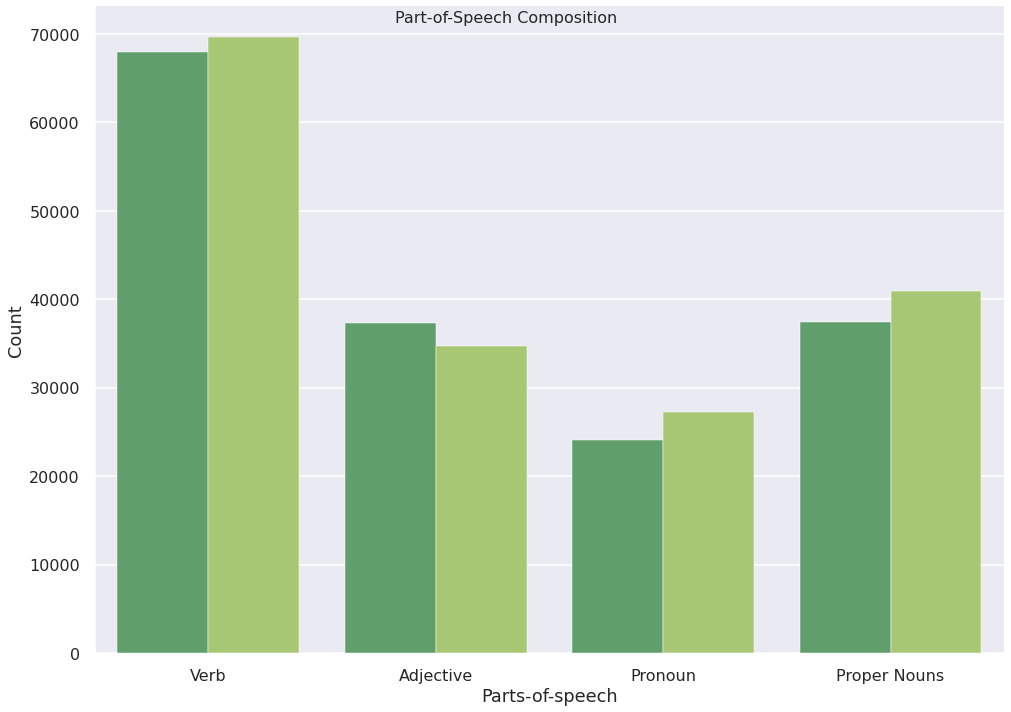

In [14]:
def pos_counter(doc):
    verb_count = 0
    adj_count = 0
    pron_count = 0
    noun_count=0
    for tok in doc:
        if tok.pos_ == "VERB":
            verb_count=verb_count+1
        elif tok.pos_ == "ADJ":
            adj_count=adj_count+1
        elif tok.pos_ == "PRON":
            pron_count=pron_count+1
        elif tok.pos_ == "PROPN":
            noun_count=noun_count+1
    return (verb_count,adj_count,pron_count,noun_count)


sarcasm_pos_list = list(pos_counter(sarcasm_doc))
non_sarcasm_pos_list = list(pos_counter(non_sarcasm_doc))

sarcasm_pos_df = {'Parts-of-speech':['Verb', 'Adjective', 'Pronoun', 'Proper Nouns'],
        'Count':sarcasm_pos_list}

non_sarcasm_pos_df = {'Parts-of-speech':['Verb', 'Adjective', 'Pronoun', 'Proper Nouns'],
        'Count':non_sarcasm_pos_list}

sarcasm_pos_df = pd.DataFrame(sarcasm_pos_df)
non_sarcasm_pos_df = pd.DataFrame(non_sarcasm_pos_df)

sarcasm_pos_df['Type'] = "Sarcasm"
non_sarcasm_pos_df['Type'] = 'Non Sarcasm'

joined = sarcasm_pos_df.append(non_sarcasm_pos_df)


sns.set_style('darkgrid')
style.use('seaborn-poster')

plot = sns.catplot(
    data=joined, kind="bar",
    x="Parts-of-speech", y="Count", hue="Type",
    palette="summer",height=10, aspect=11.7/8.27, legend=False
)

plot.fig.suptitle("Part-of-Speech Composition",
                  fontsize=16, fontdict={"weight": "light"},fontfamily='Lato')

plt.savefig('Part-of-speech.png')


In [21]:
def count_profane_words(text):
    count = 0
    for sent in text.split():
        if profanity.contains_profanity(sent) == True:
            count = count+1
    return count

print(f"Count of profane words in sarcastic comments: {count_profane_words(df_sarcasm_text)}")
print(f"Count of profane words in non sarcastic comments: {count_profane_words(df_non_sarcasm_text)}")

Count of profane words in sarcastic comments: 5766
Count of profane words in non sarcastic comments: 5333


In [22]:
df['subreddit'].value_counts()

AskReddit                65677
politics                 39496
worldnews                26377
leagueoflegends          21037
pcmasterrace             18988
                         ...  
LabiaGW                      1
Expected                     1
AnimalsStoppingFights        1
panderingfromtheright        1
Pandemic                     1
Name: subreddit, Length: 14878, dtype: int64

In [23]:
def entity_wordcloud(df):
    named_entities = []
    for sent in df:
        sent = nlp(sent)
        for ent in sent.ents:
            if ent.label_ == 'PERSON' or 'ORG' or 'GPE':
                named_entities.append(ent.text)
            
    doc = " ".join(named_entities)
    
    plt.figure(figsize=(10,5))
    wordcloud = WordCloud(background_color="white",
                      max_words=45,
                      max_font_size=30,
                      random_state=42
                     ).generate(doc)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    

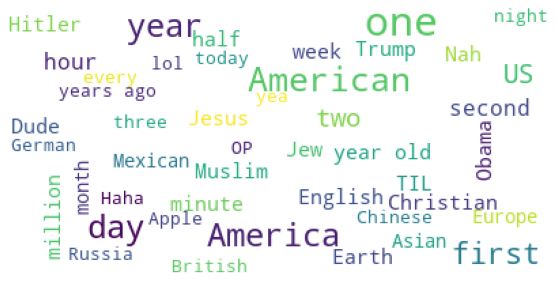

In [24]:
df_askreddit = df.loc[(df['subreddit']=='AskReddit') & (df['label']==1)]
entity_wordcloud(df_askreddit['comment'].astype(str))


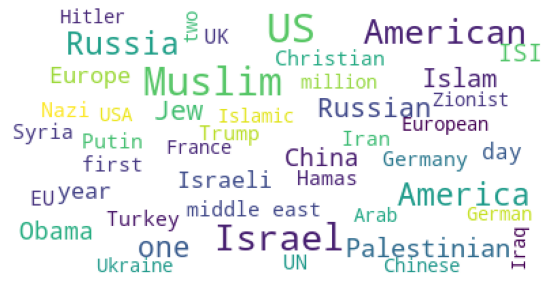

In [25]:
df_worldnews = df.loc[(df['subreddit']=='worldnews') & (df['label']==1)]
entity_wordcloud(df_worldnews['comment'].astype(str))


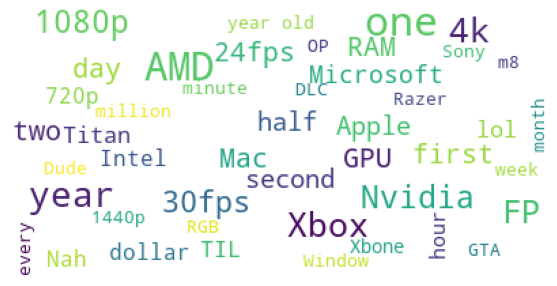

In [26]:
df_pcmasterrace = df.loc[(df['subreddit'] == 'pcmasterrace') & (df['label']==1)]
entity_wordcloud(df_pcmasterrace['comment'].astype(str))


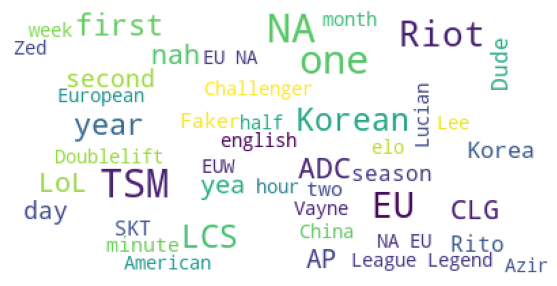

In [27]:
df_league_of_legends = df.loc[(df['subreddit'] == 'leagueoflegends') & (df['label']==1)]
entity_wordcloud(df_league_of_legends['comment'].astype(str))


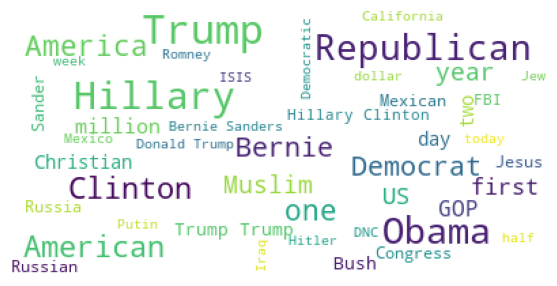

In [28]:
df_politics = df.loc[(df['subreddit'] == 'politics') & (df['label']==1)]
entity_wordcloud(df_politics['comment'].astype(str))

In [29]:
X_train,X_test,Y_train,Y_test = train_test_split(df['comment'].astype(str),df['label'],random_state=42)
lr_clf = Pipeline([('tfidf', TfidfVectorizer(ngram_range=(1,2))),('clf',  LogisticRegression(random_state= 42, solver='liblinear'))])
lr_clf.fit(X_train,Y_train)



Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(random_state=42, solver='liblinear'))])

In [30]:
print(f"The accuracy on the training set is: {lr_clf.score(X_train,Y_train)}")
print(f"The accuracy on the test set is:  {lr_clf.score(X_test,Y_test)}")

The accuracy on the training set is: 0.8171210588311334
The accuracy on the test set is:  0.7223820471929943


In [31]:
Y_pred = lr_clf.predict(X_test)
report = classification_report(Y_pred,Y_test, output_dict=True)
report = pd.DataFrame(report).transpose()
report = report.rename({"0": "Sarcastic Comments", "1": "Non Sarcastic Comments"})
report

,precision,recall,f1-score,support
Sarcastic Comments,0.743506,0.713357,0.728120,131690.000000
Non Sarcastic Comments,0.701259,0.732203,0.716397,121017.000000
accuracy,0.722382,0.722382,0.722382,0.722382
macro avg,0.722383,0.722780,0.722258,252707.000000
weighted avg,0.723275,0.722382,0.722506,252707.000000


In [32]:
eli5.explain_weights(lr_clf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+11.030,obviously
+10.721,yes because
+10.213,clearly
+9.615,because
+9.437,totally
+8.395,yeah because
+6.933,how dare
+6.923,duh
+6.618,good thing
+6.570,shitlord


In [33]:
def get_p_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df_sarcasm['p_Subjectivity'] = df_sarcasm['parent_comment'].astype(str).apply(get_p_subjectivity)
df_non_sarcasm['p_Subjectivity'] = df_non_sarcasm['parent_comment'].astype(str).apply(get_p_subjectivity)

print(f"Subjectivity score for sarcastic parent_comment: {df_sarcasm['p_Subjectivity'].sum()}")
print(f"Subjectivity score for for non sarcastic parent_comment: {df_non_sarcasm['p_Subjectivity'].sum()}")

Subjectivity score for sarcastic parent_comment: 18625.377161420864
Subjectivity score for for non sarcastic parent_comment: 18114.23931103857


In [34]:
print(f"Ups score for sarcastic comment: {df_sarcasm['ups'].sum()}")
print(f"Ups score for for non sarcastic comment: {df_non_sarcasm['ups'].sum()}")
print(f"Percentage ups: {(df_sarcasm['ups'].sum()/(df_sarcasm['ups'].sum() + df_non_sarcasm['ups'].sum())) * 100}")
print("")

print(f"Downs score for sarcastic comment: {df_sarcasm['downs'].sum()}")
print(f"Downs score for for non sarcastic comment: {df_non_sarcasm['downs'].sum()}")
print(f"Percentage downs: {(df_sarcasm['downs'].sum()/(df_sarcasm['downs'].sum() + df_non_sarcasm['downs'].sum())) * 100}")
print("")

print(f"Score for sarcastic comment: {df_sarcasm['score'].sum()}")
print(f"Score for for non sarcastic comment: {df_non_sarcasm['score'].sum()}")
print(f"Percentage score: {(df_sarcasm['score'].sum()/(df_sarcasm['score'].sum() + df_non_sarcasm['score'].sum())) * 100}")
print("")

Ups score for sarcastic comment: 261903
Ups score for for non sarcastic comment: 299991
Percentage ups: 46.61074864654187

Downs score for sarcastic comment: -6266
Downs score for for non sarcastic comment: -8290
Percentage downs: 43.04754053311349

Score for sarcastic comment: 316202
Score for for non sarcastic comment: 377806
Percentage score: 45.56172263143941

